In [ ]:
%%capture
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

In [ ]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

[2023-05-18 03:13:25] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-05-18 03:13:33] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-05-18 03:13:33] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-05-18 03:13:33] WARNING - export.py - Failed to import pytorch_quantization
[2023-05-18 03:13:33] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [ ]:
from IPython.display import clear_output

In [ ]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

In [ ]:
from super_gradients.training import models

In [ ]:
CHECKPOINT_DIR = 'checkpoints2'
trainer = Trainer(experiment_name='ppe_yolonas_run2', ckpt_root_dir=CHECKPOINT_DIR)

In [ ]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="4v0m0Q44ghy9SpeYcnuN")
project = rf.workspace("objet-detect-yolov5").project("eep_detection-u9bbd")
dataset = project.version(1).download("yolov5")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to EEP_Detection-1 in yolov5pytorch::  81%|████████▏ | 5267/6482 [00:00<00:00, 7861.83it/s]

In [ ]:
dataset_params = {
    'data_dir':'/content/EEP_Detection-1',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['Protective Helmet', 'Shield', 'Jacket', 'Dust Mask', 'Eye Wear', 'Glove', 'Protective Boots']
}


In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

In [ ]:
train_data.dataset.transforms


[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

In [ ]:
train_data.dataset.dataset_params['transforms'][1]


{'DetectionRandomAffine': {'degrees': 10.0, 'translate': 0.1, 'scales': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'filter_box_candidates': True, 'wh_thr': 2, 'area_thr': 0.1, 'ar_thr': 20}}

In [ ]:
train_data.dataset.dataset_params['transforms'][1]['DetectionRandomAffine']['degrees'] = 10.42


Caching annotations: 100%|██████████| 324/324 [00:00<00:00, 4354.55it/s]


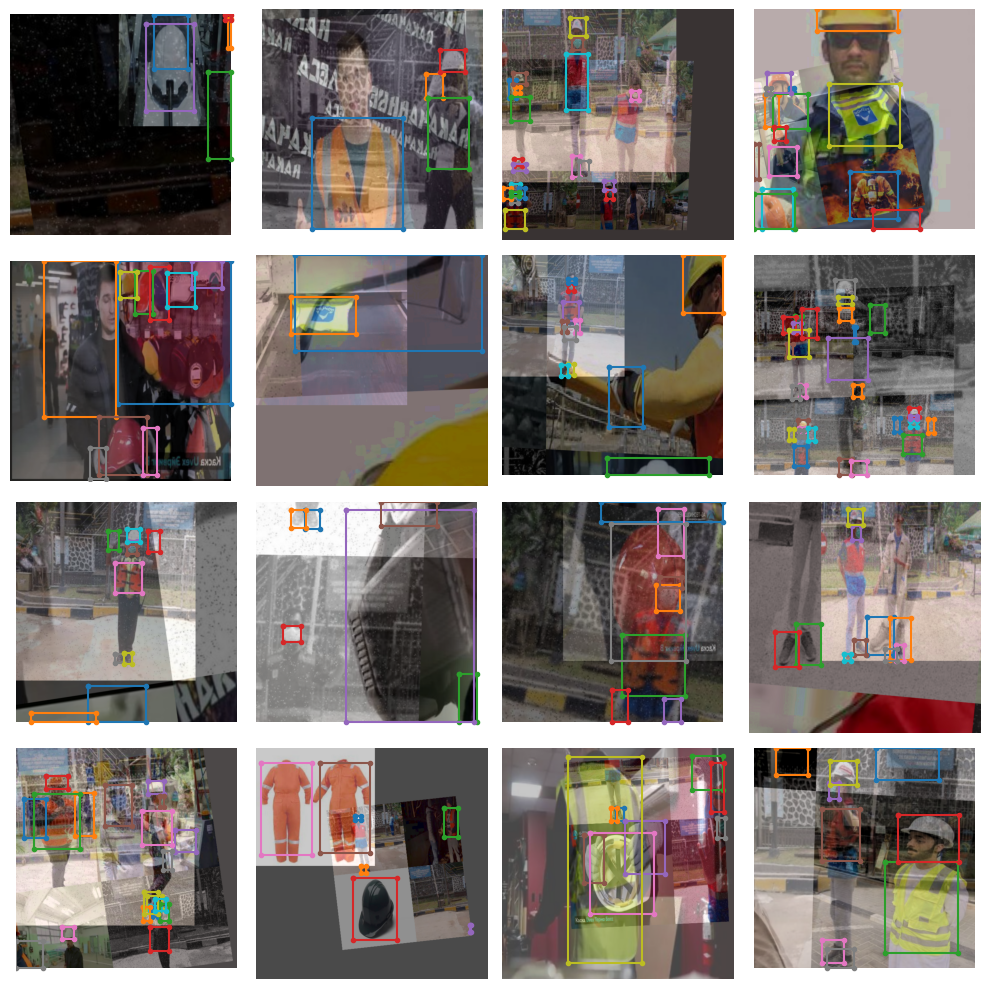

In [ ]:
train_data.dataset.plot()


In [ ]:
model = models.get('yolo_nas_s', 
                   num_classes=len(dataset_params['classes']), 
                   pretrained_weights="coco"
                   )
     

[2023-05-18 03:14:08] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth


  0%|          | 0.00/73.1M [00:00<?, ?B/s]

In [14]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 15,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [15]:
!gdown "https://drive.google.com/uc?id=1crFwrpMF1OlaJ0ZCZjBNRo9llLEVR8VQ&confirm=t"
!gdown "https://drive.google.com/uc?id=1cTIBNQ1R_7JAOURVv9cJ6P935ym_IkZ0&confirm=t"
!gdown "https://drive.google.com/uc?id=1256pNK0nQnEDT6FRLQAraTRkOY7BSprq&confirm=t"
!gdown "https://drive.google.com/uc?id=15D71z_g8uxZfXSx2ya3sy4n2-eg53meH&confirm=t"
!gdown "https://drive.google.com/uc?id=1iYW9ZAsYAaHkWZhFVwQh_ch41TMt30-Q&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1crFwrpMF1OlaJ0ZCZjBNRo9llLEVR8VQ&confirm=t
To: /content/demo.mp4
100% 42.9M/42.9M [00:01<00:00, 38.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cTIBNQ1R_7JAOURVv9cJ6P935ym_IkZ0&confirm=t
To: /content/demo3.mp4
100% 20.3M/20.3M [00:01<00:00, 17.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1256pNK0nQnEDT6FRLQAraTRkOY7BSprq&confirm=t
To: /content/demo4.mp4
100% 16.9M/16.9M [00:00<00:00, 45.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=15D71z_g8uxZfXSx2ya3sy4n2-eg53meH&confirm=t
To: /content/demonew.mp4
100% 5.39M/5.39M [00:00<00:00, 23.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iYW9ZAsYAaHkWZhFVwQh_ch41TMt30-Q&confirm=t
To: /content/demonew2.mp4
100% 1.87M/1.87M [00:00<00:00, 227MB/s]


In [16]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2023-05-18 03:17:56] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-05-18 03:18:02] INFO - utils.py - NumExpr defaulting to 2 threads.


The console stream is now moved to checkpoints2/ppe_yolonas_run2/console_May18_03_18_02.txt


[2023-05-18 03:18:10] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 2264       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         141        (len(train_loader))
    - Gradient updates per epoch:   141        (len(train_loader) / batch_accumulate)

[2023-05-18 03:20:49] INFO - base_sg_logger.py - Checkpoint saved in checkpoints2/ppe_yolonas_run2/ckpt_best.pth
[2023-05-18 03:20:49] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.0016639928799122572
[2023-05-18 03:23:25] INFO - base_sg_logger.py - Checkpoint saved in che

SUMMARY OF EPOCH 15
├── Training
│   ├── Ppyoloeloss/loss = 1.7591
│   │   ├── Best until now = 1.7938 (↘ -0.0347)
│   │   └── Epoch N-1      = 1.7938 (↘ -0.0347)
│   ├── Ppyoloeloss/loss_cls = 0.8224
│   │   ├── Best until now = 0.8416 (↘ -0.0192)
│   │   └── Epoch N-1      = 0.8416 (↘ -0.0192)
│   ├── Ppyoloeloss/loss_dfl = 0.9486
│   │   ├── Best until now = 0.9661 (↘ -0.0175)
│   │   └── Epoch N-1      = 0.9661 (↘ -0.0175)
│   └── Ppyoloeloss/loss_iou = 0.185
│       ├── Best until now = 0.1876 (↘ -0.0027)
│       └── Epoch N-1      = 0.1876 (↘ -0.0027)
└── Validation
    ├── F1@0.50 = 0.1399
    │   ├── Best until now = 0.1229 (↗ 0.017)
    │   └── Epoch N-1      = 0.1229 (↗ 0.017)
    ├── Map@0.50 = 0.8044
    │   ├── Best until now = 0.8161 (↘ -0.0117)
    │   └── Epoch N-1      = 0.8161 (↘ -0.0117)
    ├── Ppyoloeloss/loss = 1.5468
    │   ├── Best until now = 1.5402 (↗ 0.0066)
    │   └── Epoch N-1      = 1.5402 (↗ 0.0066)
    ├── Ppyoloeloss/loss_cls = 0.7225
    │   ├── Best

In [17]:
best_model = models.get('yolo_nas_s',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints2/ppe_yolonas_run2/ckpt_best.pth")

[2023-05-18 04:05:57] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints2/ppe_yolonas_run2/ckpt_best.pth EMA checkpoint.


In [18]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
                                                   top_k_predictions=300, 
                                                   num_cls=len(dataset_params['classes']), 
                                                   normalize_targets=True, 
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01, 
                                                                                                          nms_top_k=1000, 
                                                                                                          max_predictions=300,                                                                              
                                                                                                          nms_threshold=0.7)
                                                  ))

Test: 100%|██████████| 21/21 [00:11<00:00,  2.07it/s]

{'PPYoloELoss/loss_cls': 0.74369025,
 'PPYoloELoss/loss_iou': 0.15660228,
 'PPYoloELoss/loss_dfl': 0.8614195,
 'PPYoloELoss/loss': 1.5659057,
 'Precision@0.50': tensor(0.0690),
 'Recall@0.50': tensor(0.9683),
 'mAP@0.50': tensor(0.8380),
 'F1@0.50': tensor(0.1261)}

In [19]:
input_video_path = f"/content/demonew2.mp4"
output_video_path = "detections.mp4"
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"
best_model.to(device).predict(input_video_path).save(output_video_path)

Predicting Video: 100%|██████████| 65/65 [00:10<00:00,  6.15it/s]
